In [141]:
import torch 
import torch.nn as nn

import numpy as np
import math
from collections import OrderedDict

In [142]:
# MLP
class NN(nn.Module):
    """
    A simple Multi-Layer Perceptron (MLP) implemented using PyTorch.
    
    Arguments:
    ----------
    in_size : int
        The size of the input layer (number of features in the input).
    h_size : int
        The size of the hidden layers (number of neurons in each hidden layer).
    o_size : int
        The size of the output layer (number of classes or target values).
    n_layers : int, optional (default=5)
        The number of hidden layers in the network.
    
    Methods:
    --------
    forward(x):
        Defines the forward pass of the network, applying the layers sequentially to the input.
        
    Example:
    --------
    >>> model = NN(in_size=10, h_size=20, o_size=5, n_layers=3)
    >>> x = torch.randn(1, 10)  # A batch of 1 with 10 input features
    >>> output = model(x)
    """
    def __init__(self, in_size, h_size, o_size, n_layers=5):
        super(NN, self).__init__()
        # Create layers pipeline
        layers = []
        # Establish the non-linear activation function
        activation = nn.Tanh
        # Add input in the pipeline & the activation
        layers.append(("in", nn.Linear(in_size, h_size)))
        layers.append(("in_activation", activation()))
        # Add the hidden layers
        for i in range(n_layers):
            layers.append(
                ("layer_%d" %i, nn.Linear(h_size, h_size))
            )
            layers.append(("activation_layer_%d" %i, activation()))
        layers.append(("output", nn.Linear(h_size, o_size)))
        layer_dict = OrderedDict(layers)
        self.layers = nn.Sequential(layer_dict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [143]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
step_x = 0.1
step_t = 0.1
x = torch.arange(-1, 1 + step_x, step_x)
t = torch.arange(0, 1 + step_t, step_t)

# Grid: Exact Solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T.to(device)
X.requires_grad = True

# training data
boundary_condition_start = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
boundary_condition_end = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
initial_condition = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
x_train = torch.cat([boundary_condition_start, boundary_condition_end, initial_condition]).to(device)
y_bound_cond_start = torch.zeros(len(boundary_condition_start))
y_bound_cond_end = torch.zeros(len(boundary_condition_end))
y_init_cond = -torch.sin(math.pi * initial_condition[:,0])
y_train = torch.cat([y_bound_cond_start, y_bound_cond_end, y_init_cond]).unsqueeze(1).to(device)

# Initialize model
model = NN(in_size=2, h_size=20, o_size=1, n_layers=4).to(device)
criterion = nn.MSELoss()

optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1,
    max_iter=50000,
    max_eval=50000,
    history_size=50,
    tolerance_grad=1e-7,
    tolerance_change=1.0*np.finfo(float).eps,
    line_search_fn="strong_wolfe"
)

adam = torch.optim.Adam(model.parameters())

In [144]:
def loss_function(model, X, X_train, y_train, criterion):
    y_pred = model(X_train)
    loss_data = criterion(y_pred, y_train)
    u = model(X)
    
    du_dX = torch.autograd.grad(
        inputs = X,
        outputs= u,
        grad_outputs = torch.ones_like(u),
        retain_graph = True,
        create_graph = True
    )[0]

    du_dt = du_dX[:, 1]
    du_dx = du_dX[:, 0]

    du_dxx = torch.autograd.grad(
        inputs = X,
        outputs= du_dX,
        grad_outputs = torch.ones_like(du_dX),
        retain_graph = True,
        create_graph = True
    )[0][:,0]
    loss_pde = criterion(du_dt + u.squeeze() * du_dx, 0.01/math.pi * du_dxx)

    loss = loss_pde + loss_data
    loss.backward()
    return loss

In [145]:
# Training with Adam optimizer
EPOCHS = 1000
for epoch in range(EPOCHS):
    # Zero the gradients
    adam.zero_grad()
    
    # Compute the loss using the custom loss function
    loss = loss_function(model, X, x_train, y_train, criterion)
    
    # Perform a step with the Adam optimizer
    adam.step()  # Update model parameters

    # Optional: Print loss at intervals for debugging purposes
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Fine-tuning with L-BFGS optimizer
def closure():
    # Zero the gradients
    optimizer.zero_grad()
    
    # Compute the loss
    loss = loss_function(model, X, x_train, y_train, criterion)
    # print(f"L-BFGS Loss: {loss.item():.6f}")
    return loss

# Apply L-BFGS after training loop
optimizer.step(closure)
optimizer.zero_grad()
# Print final loss after L-BFGS optimization
final_loss = loss_function(model, X, x_train, y_train, criterion)
print(f"Final loss after L-BFGS: {final_loss.item():.6f}")

Epoch 0: Loss = 0.253510
Epoch 100: Loss = 0.180257
Epoch 200: Loss = 0.095107
Epoch 300: Loss = 0.086868
Epoch 400: Loss = 0.073839
Epoch 500: Loss = 0.059788
Epoch 600: Loss = 0.029741
Epoch 700: Loss = 0.024401
Epoch 800: Loss = 0.020017
Epoch 900: Loss = 0.018924
Final loss after L-BFGS: 0.000037


In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# Exact solution
X= torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(device)

with  torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

In [147]:
sns.set_style("white")
plt.figure(figsize=(5, 3), dpi=3000)

<Figure size 15000x9000 with 0 Axes>

<Figure size 15000x9000 with 0 Axes>

<Axes: >

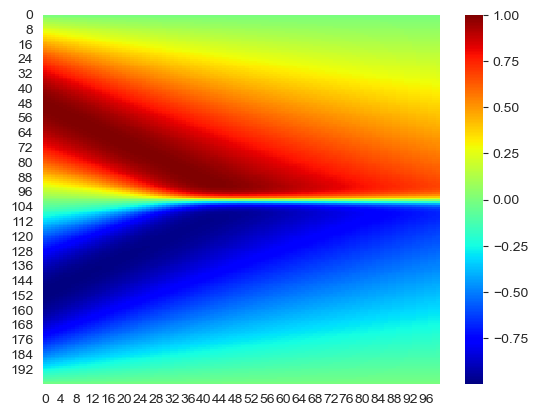

In [148]:
sns.heatmap(y_pred, cmap='jet')